In this file, the goal is to study the latent space of PEPR_Marseille using some anomalies detection method

In [1]:
import numpy as np
import pandas as pd
import umap.umap_ as umap
import seaborn as sns
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def proportion_positive(L):
    n_total = len(L)
    n_pos = np.sum(L == 1)

    return n_pos / n_total

In [3]:

reducer = umap.UMAP(n_components=2, random_state=42)

In [4]:
Embeddings_UKB= pd.read_csv("/neurospin/tmp/fred/models/2025-11-10/SC-sylv_right_UKB_16-20-03_123/Embeddings.csv")
Embeddings_HCP= pd.read_csv("/neurospin/tmp/fred/models/2025-11-10/SC-sylv_right_UKB_16-20-03_123/hcp/Embeddings.csv")
Embeddings_epilepsy= pd.read_csv("/neurospin/tmp/fred/models/2025-11-10/SC-sylv_right_UKB_16-20-03_123/epilepsy_PBS/Embeddings.csv")
Embeddings_PEPR= pd.read_csv("/neurospin/tmp/fred/models/2025-11-10/SC-sylv_right_UKB_16-20-03_123/PEPR_Marseille/Embeddings.csv")

In [5]:
selected_index = np.load("/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/notebooks/fred/PEPR_Marseille/All the subjects/histogram_non_zero/index_to_save.npy")

In [6]:
Embeddings_PEPR = Embeddings_PEPR.loc[selected_index]

In [7]:
Participants_epilepsy=pd.read_csv("/neurospin/dico/data/human/epilepsy_PBS/participants.tsv", sep="\t")

In [8]:
epilepsy_controls= Participants_epilepsy[Participants_epilepsy["Diagnosis"]=="controls"]

In [9]:
#We rename the first colomn 

Embeddings_epilepsy  = Embeddings_epilepsy.rename(columns={Embeddings_epilepsy.columns[0]: "Index"})

In [10]:
Embeddings_controls = Embeddings_epilepsy.merge(epilepsy_controls[["Index"]], on="Index", how="inner")

In [11]:
X1 = Embeddings_UKB.iloc[:,1:76] #We remove de first column because it represents the id
                                 #1:76 because there are 75 components
X2= Embeddings_HCP.iloc[:,1:76]
X3= Embeddings_controls.iloc[:,1:76]
X4= Embeddings_PEPR.iloc[:,1:76]

In [12]:
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X2=scaler.transform(X2)
X3=scaler.transform(X3)
X4=scaler.transform(X4)

UMAP

In [13]:
reducer = umap.UMAP(n_components=2, random_state=42)
X1_umap1 = reducer.fit_transform(X1)
X2_umap1 = reducer.transform(X2)
X3_umap1= reducer.transform(X3)
X4_umap1=reducer.transform(X4)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


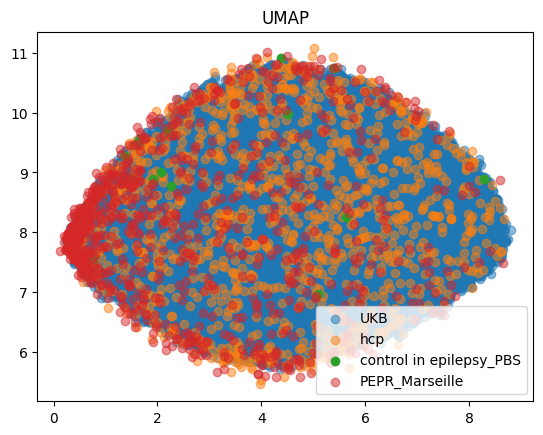

In [14]:
plt.scatter(X1_umap1[:,0], X1_umap1[:,1], alpha=0.5, label="UKB")
plt.scatter(X2_umap1[:,0], X2_umap1[:,1], alpha=0.5, label="hcp")
plt.scatter(X3_umap1[:,0], X3_umap1[:,1], label="control in epilepsy_PBS")
plt.scatter(X4_umap1[:,0], X4_umap1[:,1], label="PEPR_Marseille", alpha=0.5)

plt.legend()
plt.title('UMAP')
plt.show()

In [15]:
datasets = [X1, X2, X3, X4]
X_all = np.vstack(datasets)

y_true = np.concatenate([[i]*len(Xi) for i, Xi in enumerate(datasets)]) #true label

In [16]:
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_all)


/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [17]:
X1_umap2 = X_umap[:len(X1),:]
X2_umap2 = X_umap[len(X1):len(X1)+len(X2),:]
X3_umap2= X_umap[len(X1)+len(X2):len(X1)+len(X2)+len(X3),:]
X4_umap2= X_umap[len(X1)+len(X2)+len(X3):len(X1)+len(X2)+len(X3)+len(X4),:]

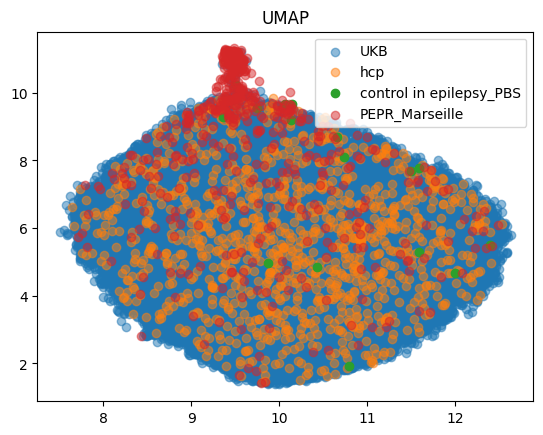

In [18]:
plt.scatter(X1_umap2[:,0], X1_umap2[:,1], alpha=0.5, label="UKB")
plt.scatter(X2_umap2[:,0], X2_umap2[:,1], alpha=0.5, label="hcp")
plt.scatter(X3_umap2[:,0], X3_umap2[:,1], label="control in epilepsy_PBS")
plt.scatter(X4_umap2[:,0], X4_umap2[:,1], label="PEPR_Marseille", alpha=0.5)

plt.legend()
plt.title('UMAP')
plt.show()

Clustering

In [19]:
dbscan = DBSCAN(eps=10**(-10), min_samples=10)
y_pred = dbscan.fit_predict(X_all)


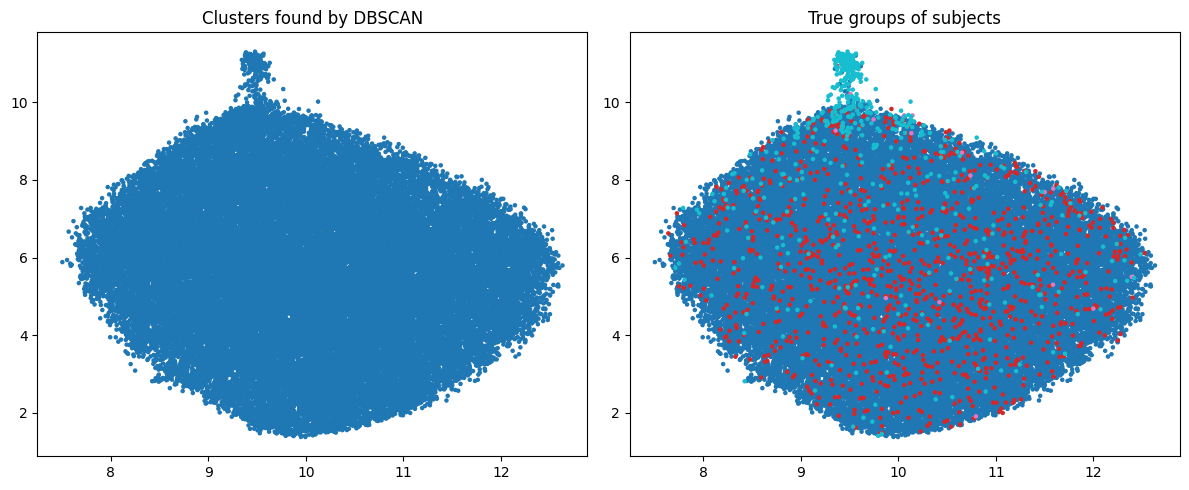

In [20]:
plt.figure(figsize=(12,5))

# Clusters found by clustering
plt.subplot(1,2,1)
plt.scatter(X_umap[:,0], X_umap[:,1], c=y_pred, cmap='tab10', s=5)
plt.title("Clusters found by DBSCAN")

# true
plt.subplot(1,2,2)
plt.scatter(X_umap[:,0], X_umap[:,1], c=y_true, cmap='tab10', s=5)
plt.title("True groups of subjects")

plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

print("ARI :", adjusted_rand_score(y_true, y_pred))
print("NMI :", normalized_mutual_info_score(y_true, y_pred))

ARI : 0.0
NMI : 0.0


In [22]:
dbscan = DBSCAN(eps=0.01, min_samples=10)
y_pred = dbscan.fit_predict(X_umap)

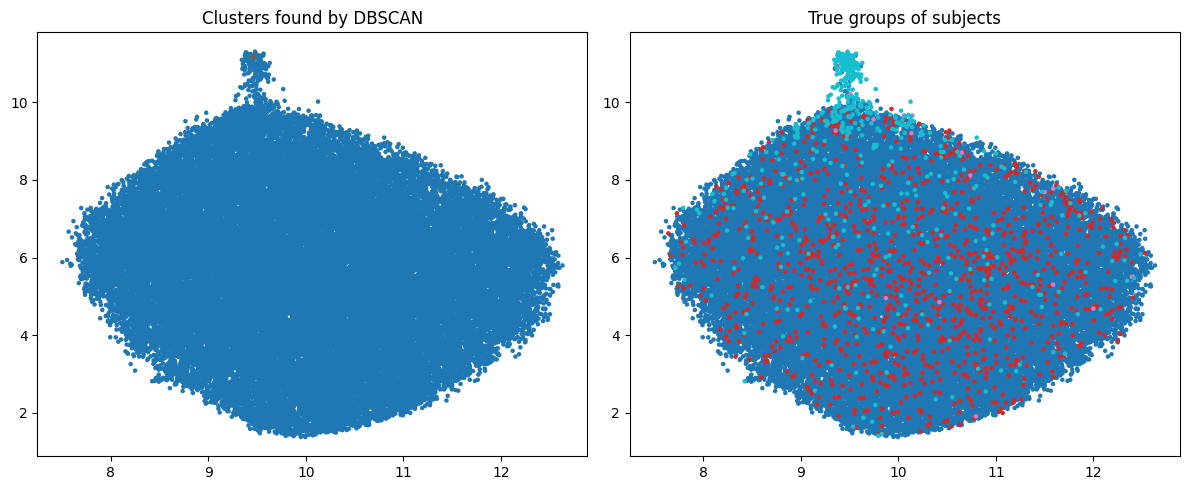

In [23]:
plt.figure(figsize=(12,5))

# Clusters found by clustering
plt.subplot(1,2,1)
plt.scatter(X_umap[:,0], X_umap[:,1], c=y_pred, cmap='tab10', s=5)
plt.title("Clusters found by DBSCAN")

# true
plt.subplot(1,2,2)
plt.scatter(X_umap[:,0], X_umap[:,1], c=y_true, cmap='tab10', s=5)
plt.title("True groups of subjects")

plt.tight_layout()
plt.show()

In [24]:
print("ARI :", adjusted_rand_score(y_true, y_pred))
print("NMI :", normalized_mutual_info_score(y_true, y_pred))

ARI : 0.13403878906857036
NMI : 0.11579722246958707


One class SVM

In [25]:
from sklearn.svm import OneClassSVM

In [26]:
clf = OneClassSVM(kernel='rbf')
clf.fit(X1)

y1 = clf.predict(X1)
y2 = clf.predict(X2)
y3 = clf.predict(X3)
y4 = clf.predict(X4)

In [27]:
print(f'UKB :{proportion_positive(y1)}')
print(f'HCP :{proportion_positive(y2)}')
print(f'Control :{proportion_positive(y3)}')
print(f'PEPR :{proportion_positive(y4)}')

UKB :0.499964650154361
HCP :0.7019748653500898
Control :0.0
PEPR :0.09212121212121212


In [28]:
clf = OneClassSVM(kernel='rbf')
clf.fit(X1_umap1)

y1 = clf.predict(X1_umap1)
y2 = clf.predict(X2_umap1)
y3 = clf.predict(X3_umap1)
y4 = clf.predict(X4_umap1)

In [29]:
print(f'UKB :{proportion_positive(y1)}')
print(f'HCP :{proportion_positive(y2)}')
print(f'Control :{proportion_positive(y3)}')
print(f'PEPR :{proportion_positive(y4)}')

UKB :0.4999882167181203
HCP :0.3599640933572711
Control :0.10526315789473684
PEPR :0.20242424242424242


In [30]:
clf = OneClassSVM(kernel='rbf')
clf.fit(X1_umap2)

y1 = clf.predict(X1_umap2)
y2 = clf.predict(X2_umap2)
y3 = clf.predict(X3_umap2)
y4 = clf.predict(X4_umap2)

In [31]:
print(f'UKB :{proportion_positive(y1)}')
print(f'HCP :{proportion_positive(y2)}')
print(f'Control :{proportion_positive(y3)}')
print(f'irm_neg :{proportion_positive(y4)}')

UKB :0.4999882167181203
HCP :0.5026929982046678
Control :0.15789473684210525
irm_neg :0.11757575757575757


In [32]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []


for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1)

    y1 = clf.predict(X1)
    y2 = clf.predict(X2)
    y3 = clf.predict(X3)
    y4 = clf.predict(X4)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


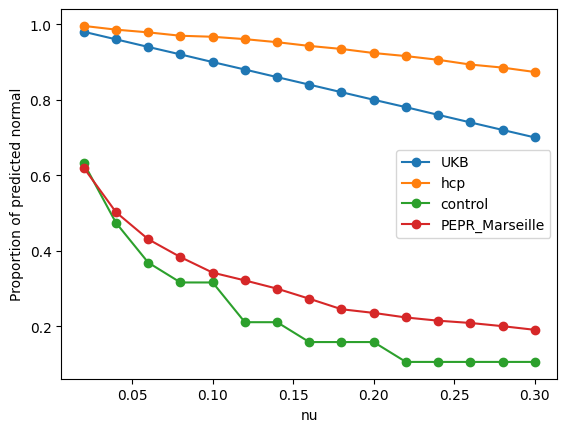

In [33]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")


plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [34]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap1)

    y1 = clf.predict(X1_umap1)
    y2 = clf.predict(X2_umap1)
    y3 = clf.predict(X3_umap1)
    y4 = clf.predict(X4_umap1)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


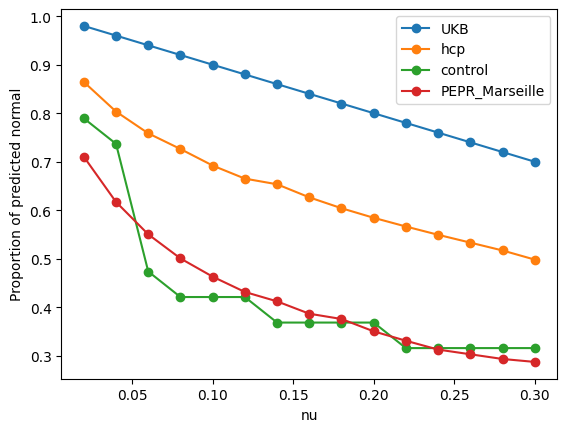

In [35]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [36]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap2)

    y1 = clf.predict(X1_umap2)
    y2 = clf.predict(X2_umap2)
    y3 = clf.predict(X3_umap2)
    y4 = clf.predict(X4_umap2)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


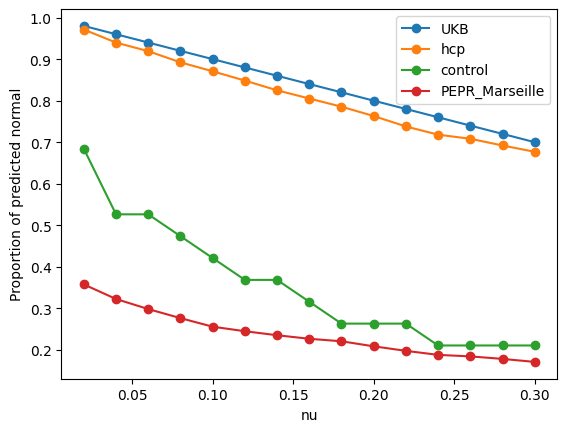

In [37]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

Isolation Forest

In [38]:
from sklearn.ensemble import IsolationForest

In [39]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

scores_UKB= []
scores_hcp= []
scores_control= []
scores_neg= []

for a in contamination:
    print(a)
    clf = IsolationForest(contamination=a, random_state=42)
    clf.fit(X1)

    scores1 = clf.decision_function(X1)
    scores2 = clf.decision_function(X2)
    scores3 = clf.decision_function(X3)
    scores4 = clf.decision_function(X4)

    y1 = clf.predict(X1)
    y2 = clf.predict(X2)
    y3 = clf.predict(X3)
    y4 = clf.predict(X4)

    scores_UKB.append(np.mean(scores1))
    scores_hcp.append(np.mean(scores2))
    scores_control.append(np.mean(scores3))
    scores_neg.append(np.mean(scores4))

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


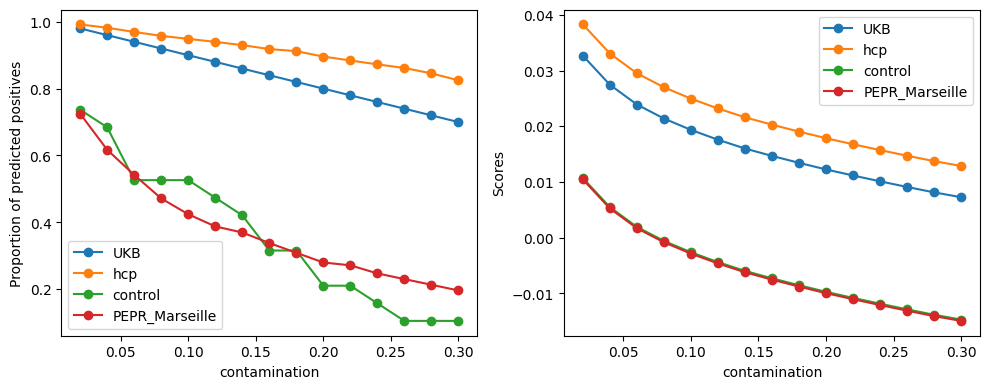

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
axes[0].plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
axes[0].plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
axes[0].plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")
axes[0].set_xlabel("contamination")
axes[0].set_ylabel("Proportion of predicted positives")
axes[0].legend()

axes[1].plot(contamination, scores_UKB, marker='o', linestyle='-', label="UKB")
axes[1].plot(contamination, scores_hcp, marker='o', linestyle='-', label="hcp")
axes[1].plot(contamination, scores_control, marker='o', linestyle='-', label="control")
axes[1].plot(contamination, scores_neg, marker='o', linestyle='-', label="PEPR_Marseille")
axes[1].set_xlabel("contamination")
axes[1].set_ylabel("Scores")
axes[1].legend()

plt.tight_layout()
plt.show()

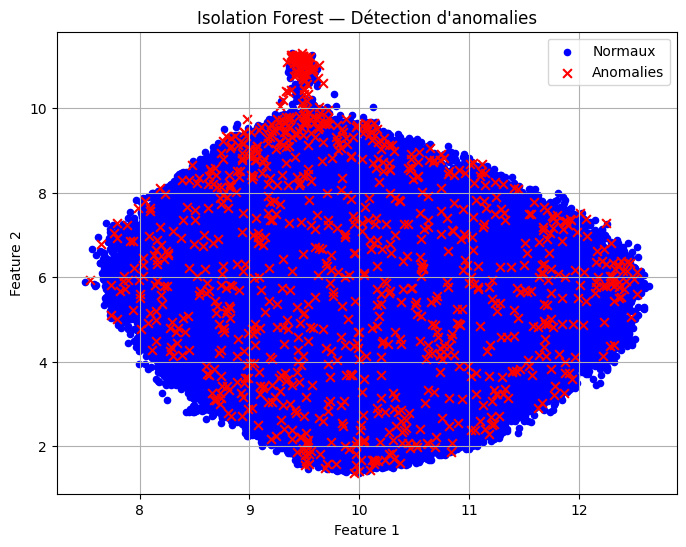

In [41]:
X_total_umap = np.concatenate((X1_umap2, X2_umap2, X3_umap2, X4_umap2), axis=0)
X_total = np.concatenate((X1, X2, X3, X4), axis=0)

clf = IsolationForest(contamination=0.02, random_state=42)
clf.fit(X1)

y_pred = clf.predict(X_total)
normal = X_total_umap[y_pred == 1]
anomaly = X_total_umap[y_pred == -1]

plt.figure(figsize=(8, 6))
plt.scatter(normal[:, 0], normal[:, 1], c='blue', s=20, label="Normaux")
plt.scatter(anomaly[:, 0], anomaly[:, 1], c='red', s=40, label="Anomalies", marker='x')

plt.title("Isolation Forest — Détection d'anomalies")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

In [42]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

scores_UKB= []
scores_hcp= []
scores_control= []
scores_neg= []

for a in contamination:

    clf = IsolationForest(contamination=a, random_state=42)
    clf.fit(X1_umap1)

    scores1 = clf.decision_function(X1_umap1)
    scores2 = clf.decision_function(X2_umap1)
    scores3 = clf.decision_function(X3_umap1)
    scores4 = clf.decision_function(X4_umap1)

    y1 = clf.predict(X1_umap1)
    y2 = clf.predict(X2_umap1)
    y3 = clf.predict(X3_umap1)
    y4 = clf.predict(X4_umap1)

    scores_UKB.append(np.mean(scores1))
    scores_hcp.append(np.mean(scores2))
    scores_control.append(np.mean(scores3))
    scores_neg.append(np.mean(scores4))


    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

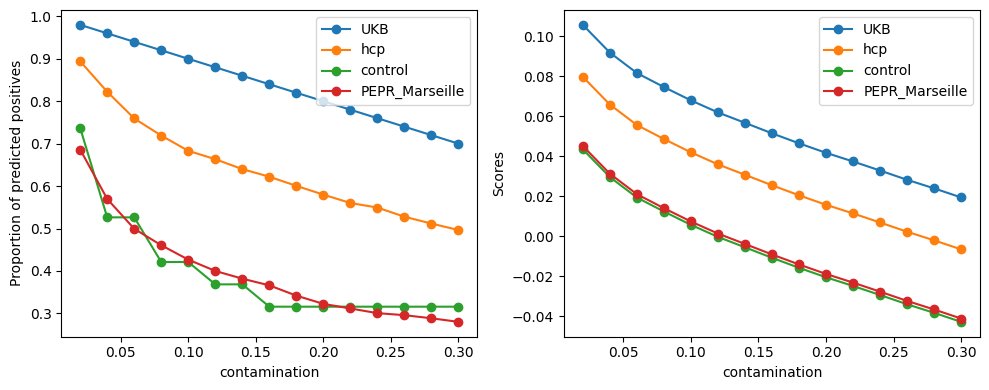

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
axes[0].plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
axes[0].plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
axes[0].plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")
axes[0].set_xlabel("contamination")
axes[0].set_ylabel("Proportion of predicted positives")
axes[0].legend()

axes[1].plot(contamination, scores_UKB, marker='o', linestyle='-', label="UKB")
axes[1].plot(contamination, scores_hcp, marker='o', linestyle='-', label="hcp")
axes[1].plot(contamination, scores_control, marker='o', linestyle='-', label="control")
axes[1].plot(contamination, scores_neg, marker='o', linestyle='-', label="PEPR_Marseille")
axes[1].set_xlabel("contamination")
axes[1].set_ylabel("Scores")
axes[1].legend()

plt.tight_layout()
plt.show()

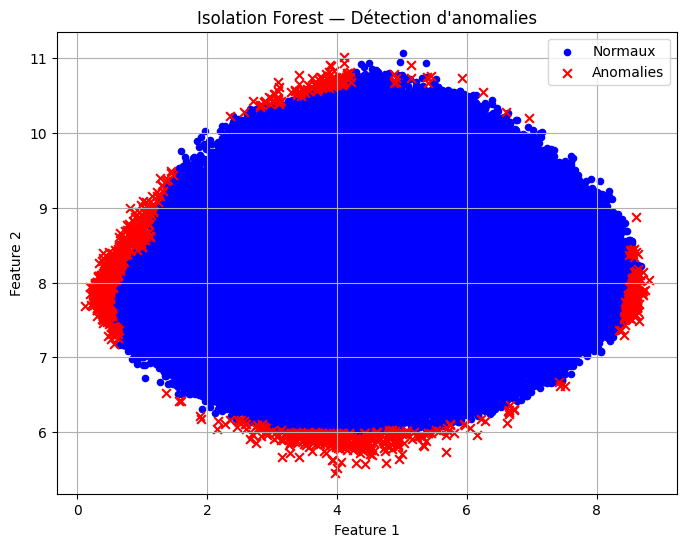

In [44]:
X_total= np.concatenate((X1_umap1, X2_umap1, X3_umap1, X4_umap1), axis=0)


clf = IsolationForest(contamination=0.02, random_state=42)
clf.fit(X1_umap1)

y_pred = clf.predict(X_total)
normal = X_total[y_pred == 1]
anomaly = X_total[y_pred == -1]

plt.figure(figsize=(8, 6))
plt.scatter(normal[:, 0], normal[:, 1], c='blue', s=20, label="Normaux")
plt.scatter(anomaly[:, 0], anomaly[:, 1], c='red', s=40, label="Anomalies", marker='x')

plt.title("Isolation Forest — Détection d'anomalies")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

scores_UKB= []
scores_hcp= []
scores_control= []
scores_neg= []

for a in contamination:

    clf = IsolationForest(contamination=a, random_state=42)
    clf.fit(X1_umap2)

    scores1 = clf.decision_function(X1_umap2)
    scores2 = clf.decision_function(X2_umap2)
    scores3 = clf.decision_function(X3_umap2)
    scores4 = clf.decision_function(X4_umap2)

    y1 = clf.predict(X1_umap2)
    y2 = clf.predict(X2_umap2)
    y3 = clf.predict(X3_umap2)
    y4 = clf.predict(X4_umap2)

    scores_UKB.append(np.mean(scores1))
    scores_hcp.append(np.mean(scores2))
    scores_control.append(np.mean(scores3))
    scores_neg.append(np.mean(scores4))

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

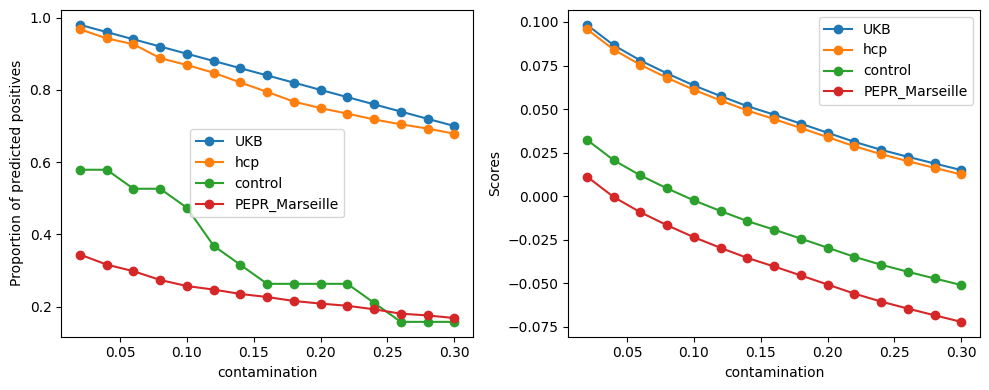

In [46]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
axes[0].plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
axes[0].plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
axes[0].plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")
axes[0].set_xlabel("contamination")
axes[0].set_ylabel("Proportion of predicted positives")
axes[0].legend()

axes[1].plot(contamination, scores_UKB, marker='o', linestyle='-', label="UKB")
axes[1].plot(contamination, scores_hcp, marker='o', linestyle='-', label="hcp")
axes[1].plot(contamination, scores_control, marker='o', linestyle='-', label="control")
axes[1].plot(contamination, scores_neg, marker='o', linestyle='-', label="PEPR_Marseille")
axes[1].set_xlabel("contamination")
axes[1].set_ylabel("Scores")
axes[1].legend()

plt.tight_layout()
plt.show()

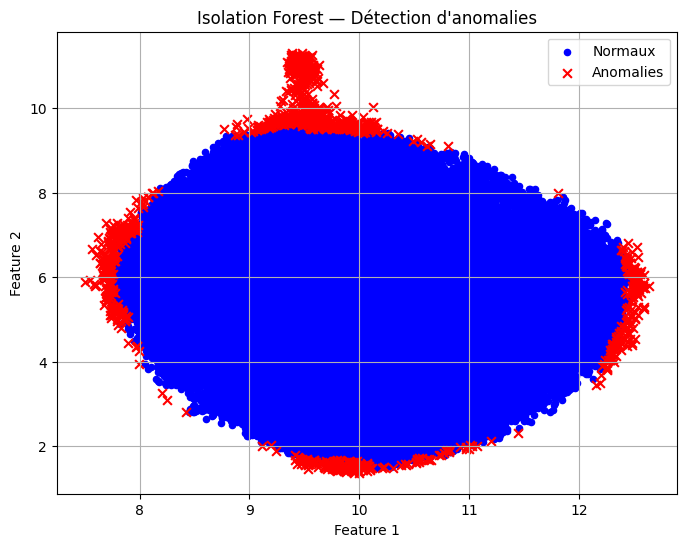

In [47]:
X_total= np.concatenate((X1_umap2, X2_umap2, X3_umap2, X4_umap2), axis=0)


clf = IsolationForest(contamination=0.02, random_state=42)
clf.fit(X1_umap2)

y_pred = clf.predict(X_total)
normal = X_total[y_pred == 1]
anomaly = X_total[y_pred == -1]

plt.figure(figsize=(8, 6))
plt.scatter(normal[:, 0], normal[:, 1], c='blue', s=20, label="Normaux")
plt.scatter(anomaly[:, 0], anomaly[:, 1], c='red', s=40, label="Anomalies", marker='x')

plt.title("Isolation Forest — Détection d'anomalies")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()

LOF (Local Otlier Factor)

In [48]:
from sklearn.neighbors import LocalOutlierFactor

In [49]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []
prop_positive_pos= []
prop_positive_interrupted_cs= []

for a in contamination:
    print(a)
    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1)
    y1 = lof.predict(X1)
    y2 = lof.predict(X2)
    y3 = lof.predict(X3)
    y4 = lof.predict(X4)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


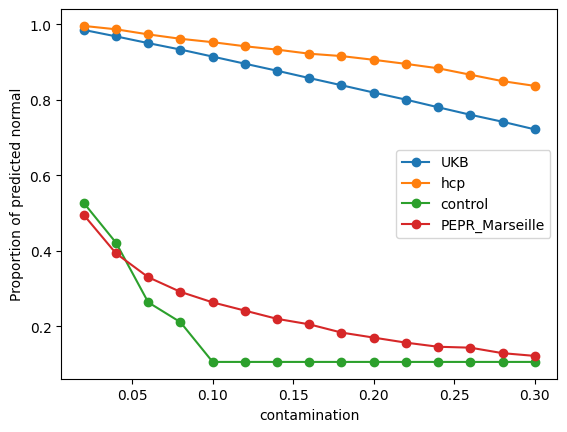

In [50]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [51]:
contamination= np.arange(0.01,0.51,0.01)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap1)
    y1 = lof.predict(X1_umap1)
    y2 = lof.predict(X2_umap1)
    y3 = lof.predict(X3_umap1)
    y4 = lof.predict(X4_umap1)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

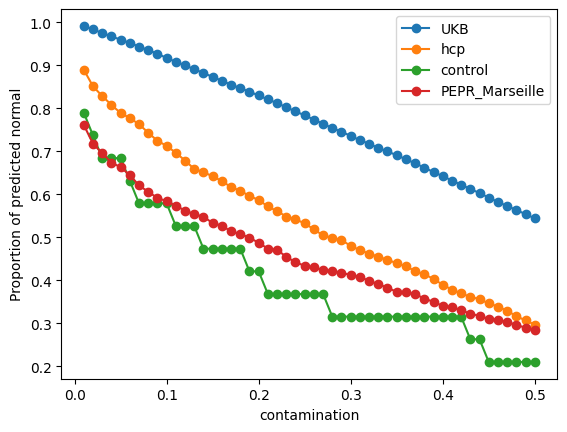

In [52]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [53]:
contamination= np.arange(0.01,0.51,0.01)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap2)
    y1 = lof.predict(X1_umap2)
    y2 = lof.predict(X2_umap2)
    y3 = lof.predict(X3_umap2)
    y4 = lof.predict(X4_umap2)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))


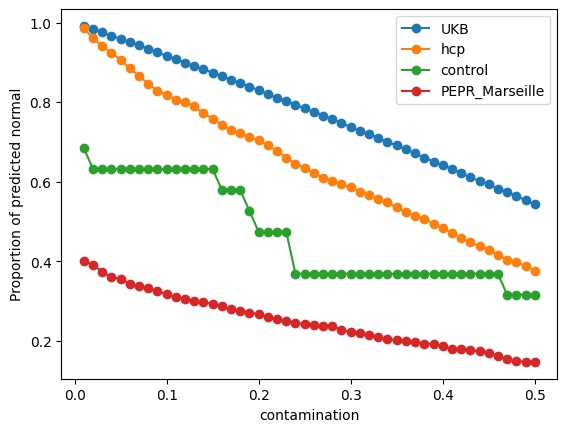

In [54]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

ABOD (Angle-Based Outliers Detection)

In [55]:
from pyod.models.abod import ABOD

In [56]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:
    print(a)
    clf = ABOD(contamination=a)
    clf.fit(X1)

    y1 =1-  clf.predict(X1)  #1=normal, 0= outlier
    y2 = 1- clf.predict(X2)
    y3 = 1- clf.predict(X3)
    y4 = 1-  clf.predict(X4)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


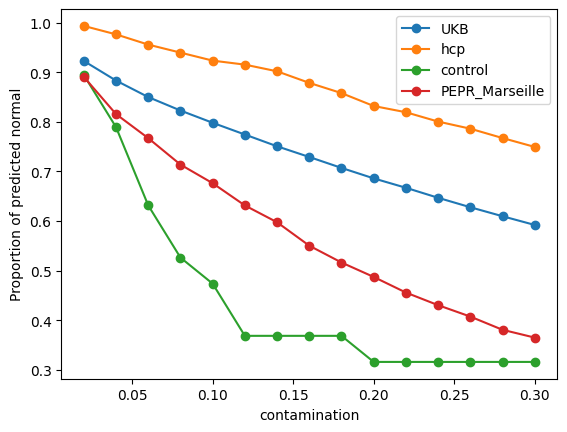

In [57]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [58]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:
    print(a)
    clf = ABOD(contamination=a)
    clf.fit(X1_umap1)

    y1 =1-  clf.predict(X1_umap1)  #1=normal, 0= outlier
    y2 = 1- clf.predict(X2_umap1)
    y3 = 1- clf.predict(X3_umap1)
    y4 = 1-  clf.predict(X4_umap1)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


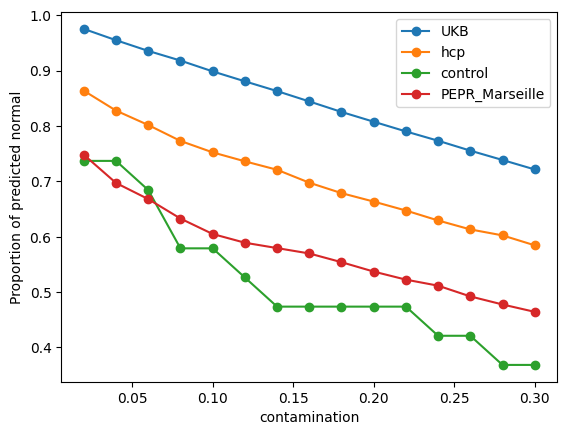

In [59]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [60]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:

    clf = ABOD(contamination=a)
    clf.fit(X1_umap2)

    y1 =1-  clf.predict(X1_umap2)  #1=normal, 0= outlier
    y2 = 1- clf.predict(X2_umap2)
    y3 = 1- clf.predict(X3_umap2)
    y4 = 1-  clf.predict(X4_umap2)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

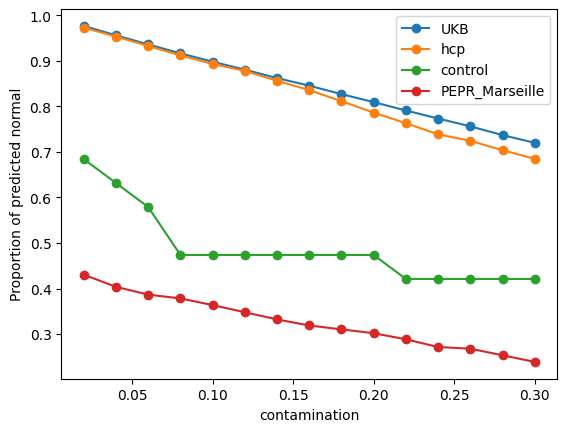

In [61]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

Feature bagging

In [62]:
from sklearn.svm import OneClassSVM

In [63]:
nu = np.arange(0.02,0.21,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

n_models = 51 
M=75 #nbres de dimensions      
subset_size = M // 2  
for u in nu:
    print(u)
    predictions_all1 = np.zeros((X1.shape[0], n_models))
    predictions_all2 = np.zeros((X2.shape[0], n_models))
    predictions_all3 = np.zeros((X3.shape[0], n_models))
    predictions_all4 = np.zeros((X4.shape[0], n_models))

    for i in range(n_models):
        # Sélection aléatoire d'un sous-ensemble de features
        features_idx = np.random.choice(M, subset_size, replace=False)
        X_subset1 = X1[:, features_idx]
        X_subset2 = X2[:, features_idx]
        X_subset3 = X3[:, features_idx]
        X_subset4 = X4[:, features_idx]

        clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
        clf.fit(X_subset1)
        y_pred1 = clf.predict(X_subset1)
        y_pred2 = clf.predict(X_subset2)
        y_pred3 = clf.predict(X_subset3)
        y_pred4 = clf.predict(X_subset4)

        predictions_all1[:, i] = y_pred1
        predictions_all2[:, i] = y_pred2
        predictions_all3[:, i] = y_pred3
        predictions_all4[:, i] = y_pred4

    y1 = (predictions_all1.mean(axis=1) > 0).astype(int)
    y2 = (predictions_all2.mean(axis=1) > 0).astype(int)
    y3 = (predictions_all3.mean(axis=1) > 0).astype(int)
    y4 = (predictions_all4.mean(axis=1) > 0).astype(int)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998


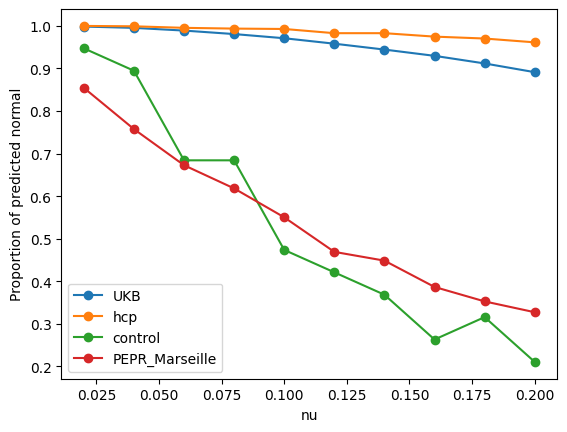

In [64]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

One-class SVM

In [65]:
from sklearn.svm import OneClassSVM

Umap 5D

In [66]:
reducer = umap.UMAP(n_components=5, random_state=42)
X1_umap5 = reducer.fit_transform(X1)
X2_umap5 = reducer.transform(X2)
X3_umap5= reducer.transform(X3)
X4_umap5=reducer.transform(X4)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [67]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap5)

    y1 = clf.predict(X1_umap5)
    y2 = clf.predict(X2_umap5)
    y3 = clf.predict(X3_umap5)
    y4 = clf.predict(X4_umap5)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


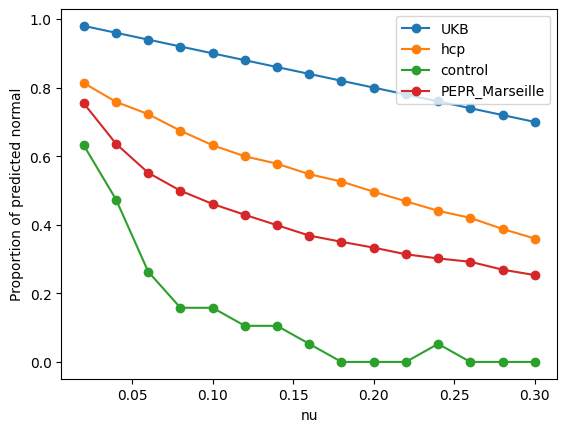

In [68]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

UMAP 10D

In [69]:
reducer = umap.UMAP(n_components=10, random_state=42)
X1_umap10 = reducer.fit_transform(X1)
X2_umap10 = reducer.transform(X2)
X3_umap10 = reducer.transform(X3)
X4_umap10 =reducer.transform(X4)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [70]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap10)

    y1 = clf.predict(X1_umap10)
    y2 = clf.predict(X2_umap10)
    y3 = clf.predict(X3_umap10)
    y4 = clf.predict(X4_umap10)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


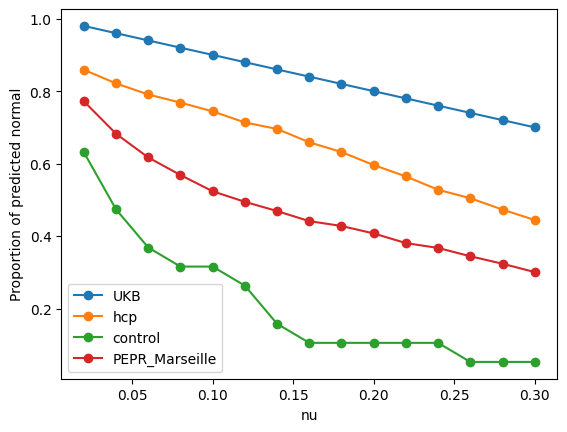

In [71]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

Umap 20D

In [72]:
reducer = umap.UMAP(n_components=20, random_state=42)
X1_umap20 = reducer.fit_transform(X1)
X2_umap20 = reducer.transform(X2)
X3_umap20 = reducer.transform(X3)
X4_umap20 =reducer.transform(X4)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [73]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap20)

    y1 = clf.predict(X1_umap20)
    y2 = clf.predict(X2_umap20)
    y3 = clf.predict(X3_umap20)
    y4 = clf.predict(X4_umap20)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))


0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


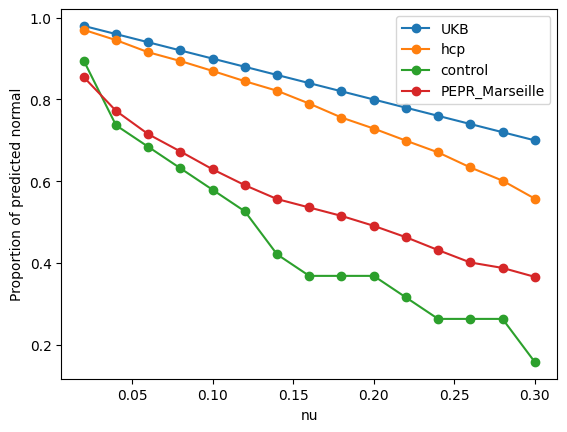

In [74]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

umap 30D

In [75]:
reducer = umap.UMAP(n_components=30, random_state=42)
X1_umap30 = reducer.fit_transform(X1)
X2_umap30 = reducer.transform(X2)
X3_umap30 = reducer.transform(X3)
X4_umap30 =reducer.transform(X4)

/neurospin/dico/fred/Runs/01_betaVAE/Program/2023_jlaval_STSbabies/betaVAE/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [76]:
nu= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for u in nu:
    print(u)
    clf = OneClassSVM(kernel='rbf', gamma='scale', nu=u)
    clf.fit(X1_umap30)

    y1 = clf.predict(X1_umap30)
    y2 = clf.predict(X2_umap30)
    y3 = clf.predict(X3_umap30)
    y4 = clf.predict(X4_umap30)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

0.02
0.04
0.06
0.08
0.1
0.12000000000000001
0.13999999999999999
0.16
0.18
0.19999999999999998
0.22
0.24
0.26
0.28
0.30000000000000004


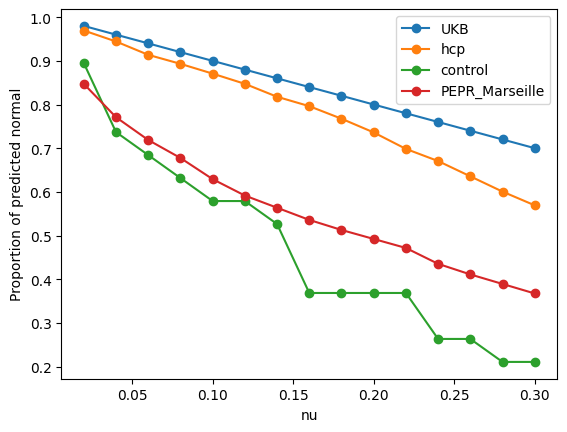

In [77]:
plt.plot(nu, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(nu, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(nu, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(nu, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("nu")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

LOF

In [78]:
from sklearn.neighbors import LocalOutlierFactor

In [79]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap5)
    y1 = lof.predict(X1_umap5)
    y2 = lof.predict(X2_umap5)
    y3 = lof.predict(X3_umap5)
    y4 = lof.predict(X4_umap5)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

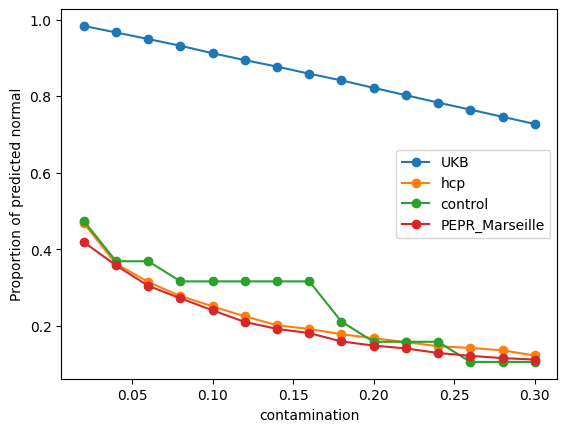

In [80]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [81]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap10)
    y1 = lof.predict(X1_umap10)
    y2 = lof.predict(X2_umap10)
    y3 = lof.predict(X3_umap10)
    y4 = lof.predict(X4_umap10)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

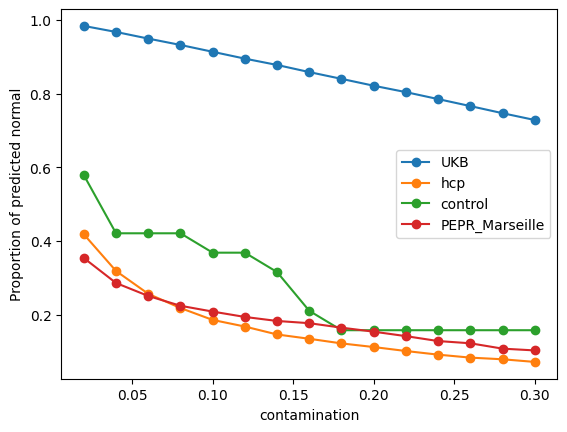

In [82]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [83]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap20)
    y1 = lof.predict(X1_umap20)
    y2 = lof.predict(X2_umap20)
    y3 = lof.predict(X3_umap20)
    y4 = lof.predict(X4_umap20)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

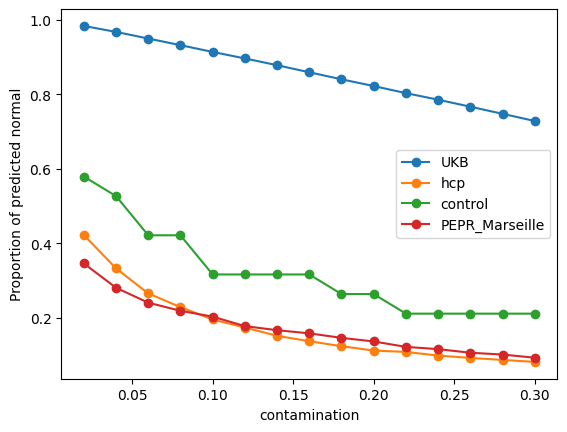

In [84]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()

In [85]:
contamination= np.arange(0.02,0.31,0.02)

prop_positive_UKB= []
prop_positive_hcp= []
prop_positive_control= []
prop_positive_neg= []

for a in contamination:

    lof = LocalOutlierFactor(contamination=a, novelty=True)
    lof.fit(X1_umap30)
    y1 = lof.predict(X1_umap30)
    y2 = lof.predict(X2_umap30)
    y3 = lof.predict(X3_umap30)
    y4 = lof.predict(X4_umap30)

    prop_positive_UKB.append(proportion_positive(y1))
    prop_positive_hcp.append(proportion_positive(y2))
    prop_positive_control.append(proportion_positive(y3))
    prop_positive_neg.append(proportion_positive(y4))

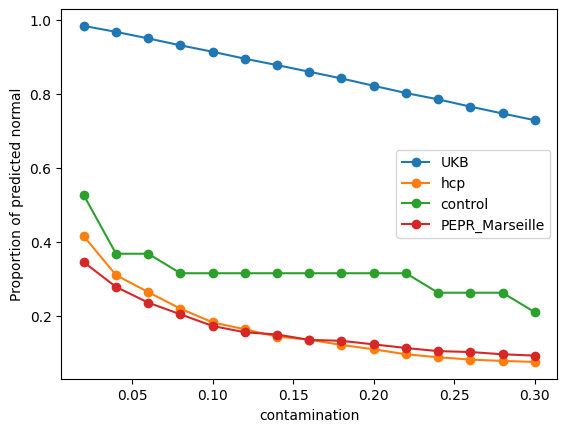

In [86]:
plt.plot(contamination, prop_positive_UKB, marker='o', linestyle='-', label="UKB")
plt.plot(contamination, prop_positive_hcp, marker='o', linestyle='-', label="hcp")
plt.plot(contamination, prop_positive_control, marker='o', linestyle='-', label="control")
plt.plot(contamination, prop_positive_neg, marker='o', linestyle='-', label="PEPR_Marseille")

plt.xlabel("contamination")
plt.ylabel("Proportion of predicted normal")
plt.legend()
plt.show()